# Reinforcement Learning Tutorial

<a href="https://colab.research.google.com/github/feryal/rl_mlss_2020/blob/master/RL_Tutorial_MLSS_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Contact us at feryal@google.com, mwhoffman@google.com & bshahr@google.com for any questions/comments :)
>
>Special thanks to Gheorghe Comanici, Diana Borsa & Nando de Freitas.
>
>This Tutorial is based on the [EEML 2020 RL tutorial](https://github.com/eemlcommunity/PracticalSessions2020/tree/master/rl) and extended to also cover policy-based methods.


Content Reviewer / Editor : Keshav Ramji



The tutorial covers a number of important reinforcement learning (RL) algorithms. This tutorial is split into four parts:

  0. refresher on environments and agents
  1. value-based methods: tabular 
  2. value-based methods: function approximation 
  3. policy-based methods

We will first guide you through the general interaction between RL agents and environments, where the agents goal is to take actions in order to maximize returns. Next, we will implement SARSA, and $\color{green}Q$-learning for a simple grid-world environment. The core ideas in the latter will be scaled to more complex MDPs through the use of function approximation. For that we will provide a short introduction to deep RL and the DQN algorithm. We will then switch to policy gradients and implement the REINFORCE algorithm and train it on the gridworld environment. We will later see that these agents can then be interfaced with other environments such as CartPole. 

## Initialize Penn Grader

In [1]:
%%capture
!pip install penngrader

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os 
import sys

In [3]:
# For autograder only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


In [4]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 57931095 # YOUR PENN-ID GOES HERE AS AN INTEGER#

In [5]:
import penngrader.grader
grader = penngrader.grader.PennGrader(homework_id = 'CIS_5200_202230_HW_Reinforcement_Learning_WS2', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 57931095

Make sure this correct or we will not be able to store your grade


# Overview

The agent interacts with the environment in a loop corresponding to the following diagram. The environment defines a set of <font color='blue'>**actions**</font>  that an agent can take.  The agent takes an action informed by the <font color='redorange'>**observations**</font> it recieves, and will get a <font color='green'>**reward**</font> from the environment after each action. The goal in RL is to find an agent whose actions maximize the total accumulation of rewards obtained from the environment. 


<center><img src="https://drive.google.com/uc?id=1KktLm5mdWx1ORotxeYCq1WcQHkXzRT4F" width="500" /></center>


In the first part of the tutorial we focus on <font color='green'>**value based methods**</font>, where agents maintain a value for all state-action pairs and use those estimates to choose actions that maximize that <font color='green'>**value**</font> (instead of maintaining a policy directly, like in <font color='blue'>**policy gradient methods**</font>). 

We represent the <font color='green'>**action-value function**</font> (otherwise known as $\color{green}Q$-function associated with following/employing a policy $\pi$ in a given MDP as:

$$ \color{green}Q^{\color{blue}{\pi}}(\color{red}{s},\color{blue}{a}) = \mathbb{E}_{\tau \sim P^{\color{blue}{\pi}}} \left[ \sum_t \gamma^t \color{green}{r_t}| s_0=\color{red}s,a_0=\color{blue}{a} \right]$$

where $\tau = \{\color{red}{s_0}, \color{blue}{a_0}, \color{green}{r_0}, \color{red}{s_1}, \color{blue}{a_1}, \color{green}{r_1}, \cdots \}$


Recall that efficient value estimations are based on the famous **_Bellman Expectation Equation_**:

$$ \color{green}Q^\color{blue}{\pi}(\color{red}{s},\color{blue}{a}) =    \sum_{\color{red}{s'}\in \color{red}{\mathcal{S}}} 
\color{purple}P(\color{red}{s'} |\color{red}{s},\color{blue}{a})
\left(
  \color{green}{R}(\color{red}{s},\color{blue}{a}, \color{red}{s'}) 
  + \gamma \color{green}V^\color{blue}{\pi}(\color{red}{s'}) 
  \right)
$$

where $\color{green}V^\color{blue}{\pi}$ is the expected $\color{green}Q^\color{blue}{\pi}$ value for a particular state, i.e. $\color{green}V^\color{blue}{\pi}(\color{red}{s}) = \sum_{\color{blue}{a} \in \color{blue}{\mathcal{A}}} \color{blue}{\pi}(\color{blue}{a} |\color{red}{s}) \color{green}Q^\color{blue}{\pi}(\color{red}{s},\color{blue}{a})$.

1. [Acme](https://github.com/deepmind/acme) is a library of reinforcement learning (RL) agents and agent building blocks. Acme strives to expose simple, efficient, and readable agents, that serve both as reference implementations of popular algorithms and as strong baselines, while still providing enough flexibility to do novel research. The design of Acme also attempts to provide multiple points of entry to the RL problem at differing levels of complexity.


2. [Sonnet](https://github.com/deepmind/sonnet) is a simple neural network library for Tensorflow.

3. [dm_env](https://github.com/deepmind/dm_env): DeepMind Environment API, which will be covered in more details in the [Environment subsection](https://colab.research.google.com/drive/1oKyyhOFAFSBTpVnmuOm9HXh5D5ekqhh5#scrollTo=I6KuVGSk4uc9) below.

In [6]:
#@title Install requirements  { form-width: "30%" }

!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[tf]
!pip install dm-acme[envs]
!pip install dm-env
!sudo apt-get install -y xvfb ffmpeg
!pip install imageio

from IPython.display import clear_output
clear_output()

In [7]:
#@title Import modules  { form-width: "30%" }
!pip install tensorflow
import IPython
from typing import Callable, Optional, Sequence
import acme
from acme import environment_loop
from acme import specs
from acme import wrappers
from acme.utils import tree_utils
from acme.agents.tf import dqn
# from acme.utils import counting
from acme.utils import loggers
import base64
import collections
import dm_env
import enum
# import functools
import gym
# import io
import imageio
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import sonnet as snt
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
import time

import warnings
warnings.filterwarnings('ignore')



np.set_printoptions(precision=3, suppress=1)

plt.style.use('seaborn-notebook')
plt.style.use('seaborn-whitegrid')



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


RuntimeError: ignored

/usr/local/lib/python3.8/dist-packages/sonnet/src/types.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  BoolLike = Union[bool, np.bool, TensorLike]


# Part 0: Environment & Agent


For this practical session we will focus on a **simple grid world** environment,which consists of a 9 x 10 grid of either wall or empty cells, depicted in black and white, respectively. The smiling agent starts from an initial location and needs to navigate to reach the goal square.

<center>
<img src="https://drive.google.com/uc?id=163QdCqrPybJVVO0NhDxpun5O0YZmCnsI" width="500" />
</center>

 


In [8]:
#@title Implement GridWorld { form-width: "30%" }


class ObservationType(enum.IntEnum):
  STATE_INDEX = enum.auto()
  AGENT_ONEHOT = enum.auto()
  GRID = enum.auto()
  AGENT_GOAL_POS = enum.auto()


class GridWorld(dm_env.Environment):

  def __init__(self,
               layout,
               start_state,
               goal_state=None,
               observation_type=ObservationType.STATE_INDEX,
               discount=0.9,
               penalty_for_walls=-5,
               reward_goal=10,
               max_episode_length=None,
               randomize_goals=False):
    """Build a grid environment.

    Simple gridworld defined by a map layout, a start and a goal state.

    Layout should be a NxN grid, containing:
      * 0: empty
      * -1: wall
      * Any other positive value: value indicates reward; episode will terminate

    Args:
      layout: NxN array of numbers, indicating the layout of the environment.
      start_state: Tuple (y, x) of starting location.
      goal_state: Optional tuple (y, x) of goal location. Will be randomly
        sampled once if None.
      observation_type: Enum observation type to use. One of:
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the 
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels. 
          First channel contains walls (1 if wall, 0 otherwise), second the 
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with 
          (agent_y, agent_x, goal_y, goal_x)
      discount: Discounting factor included in all Timesteps.
      penalty_for_walls: Reward added when hitting a wall (should be negative).
      reward_goal: Reward added when finding the goal (should be positive).
      max_episode_length: If set, will terminate an episode after this many 
        steps.
      randomize_goals: If true, randomize goal at every episode.
    """
    if observation_type not in ObservationType:
      raise ValueError('observation_type should be a ObservationType instace.')
    self._layout = np.array(layout)
    self._start_state = start_state
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount
    self._penalty_for_walls = penalty_for_walls
    self._reward_goal = reward_goal
    self._observation_type = observation_type
    self._layout_dims = self._layout.shape
    self._max_episode_length = max_episode_length
    self._num_episode_steps = 0
    self._randomize_goals = randomize_goals
    if goal_state is None:
      # Randomly sample goal_state if not provided
      goal_state = self._sample_goal()
    self.goal_state = goal_state

  def _sample_goal(self):
    """Randomly sample reachable non-starting state."""
    # Sample a new goal
    n = 0
    max_tries = 1e5
    while n < max_tries:
      goal_state = tuple(np.random.randint(d) for d in self._layout_dims)
      if goal_state != self._state and self._layout[goal_state] == 0:
        # Reachable state found!
        return goal_state
      n += 1
    raise ValueError('Failed to sample a goal state.')

  @property
  def layout(self):
    return self._layout

  @property
  def number_of_states(self):
    return self._number_of_states

  @property
  def goal_state(self):
    return self._goal_state
  
  @property
  def start_state(self):
    return self._start_state
  
  @property
  def state(self):
    return self._state

  def set_state(self, x, y):
    self._state = (y, x)

  @goal_state.setter
  def goal_state(self, new_goal):
    if new_goal == self._state or self._layout[new_goal] < 0:
      raise ValueError('This is not a valid goal!')
    # Zero out any other goal
    self._layout[self._layout > 0] = 0
    # Setup new goal location
    self._layout[new_goal] = self._reward_goal
    self._goal_state = new_goal

  def observation_spec(self):
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      return specs.Array(
          shape=self._layout_dims,
          dtype=np.float32,
          name='observation_agent_onehot')
    elif self._observation_type is ObservationType.GRID:
      return specs.Array(
          shape=self._layout_dims + (3,),
          dtype=np.float32,
          name='observation_grid')
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return specs.Array(
          shape=(4,), dtype=np.float32, name='observation_agent_goal_pos')
    elif self._observation_type is ObservationType.STATE_INDEX:
      return specs.DiscreteArray(
          self._number_of_states, dtype=int, name='observation_state_index')

  def action_spec(self):
    return specs.DiscreteArray(4, dtype=int, name='action')

  def get_obs(self):
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      obs = np.zeros(self._layout.shape, dtype=np.float32)
      # Place agent
      obs[self._state] = 1
      return obs
    elif self._observation_type is ObservationType.GRID:
      obs = np.zeros(self._layout.shape + (3,), dtype=np.float32)
      obs[..., 0] = self._layout < 0
      obs[self._state[0], self._state[1], 1] = 1
      obs[self._goal_state[0], self._goal_state[1], 2] = 1
      return obs
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return np.array(self._state + self._goal_state, dtype=np.float32)
    elif self._observation_type is ObservationType.STATE_INDEX:
      y, x = self._state
      return y * self._layout.shape[1] + x

  def reset(self):
    self._state = self._start_state
    self._num_episode_steps = 0
    if self._randomize_goals:
      self.goal_state = self._sample_goal()
    return dm_env.TimeStep(
        step_type=dm_env.StepType.FIRST,
        reward=None,
        discount=None,
        observation=self.get_obs())

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError(
          'Invalid action: {} is not 0, 1, 2, or 3.'.format(action))

    new_y, new_x = new_state
    step_type = dm_env.StepType.MID
    if self._layout[new_y, new_x] == -1:  # wall
      reward = self._penalty_for_walls
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
      step_type = dm_env.StepType.LAST

    self._state = new_state
    self._num_episode_steps += 1
    if (self._max_episode_length is not None and
        self._num_episode_steps >= self._max_episode_length):
      step_type = dm_env.StepType.LAST
    return dm_env.TimeStep(
        step_type=step_type,
        reward=np.float32(reward),
        discount=discount,
        observation=self.get_obs())

  def plot_grid(self, add_start=True):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout <= -1, interpolation='nearest')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    # Add start/goal
    if add_start:
      plt.text(
          self._start_state[1],
          self._start_state[0],
          r'$\mathbf{S}$',
          fontsize=16,
          ha='center',
          va='center')
    plt.text(
        self._goal_state[1],
        self._goal_state[0],
        r'$\mathbf{G}$',
        fontsize=16,
        ha='center',
        va='center')
    h, w = self._layout.shape
    for y in range(h - 1):
      plt.plot([-0.5, w - 0.5], [y + 0.5, y + 0.5], '-k', lw=2)
    for x in range(w - 1):
      plt.plot([x + 0.5, x + 0.5], [-0.5, h - 0.5], '-k', lw=2)
      
  def plot_state(self, return_rgb=False):
    self.plot_grid(add_start=False)
    # Add the agent location
    plt.text(
        self._state[1],
        self._state[0],
        u'😃',
        fontname='symbola',
        fontsize=18,
        ha='center',
        va='center',
    )
    if return_rgb:
      fig = plt.gcf()
      plt.axis('tight')
      plt.subplots_adjust(0, 0, 1, 1, 0, 0)
      fig.canvas.draw()
      data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
      w, h = fig.canvas.get_width_height()
      data = data.reshape((h, w, 3))
      plt.close(fig)
      return data

  def plot_policy(self, policy):
    action_names = [
        r'$\uparrow$', r'$\rightarrow$', r'$\downarrow$', r'$\leftarrow$'
    ]
    self.plot_grid()
    plt.title('Policy Visualization')
    h, w = self._layout.shape
    for y in range(h):
      for x in range(w):
        # if ((y, x) != self._start_state) and ((y, x) != self._goal_state):
        if (y, x) != self._goal_state:
          action_name = action_names[policy[y, x]]
          plt.text(x, y, action_name, ha='center', va='center')

  def plot_greedy_policy(self, q):
    greedy_actions = np.argmax(q, axis=2)
    self.plot_policy(greedy_actions)
    

def build_gridworld_task(task,
                         discount=0.9,
                         penalty_for_walls=-5,
                         observation_type=ObservationType.STATE_INDEX,
                         max_episode_length=200):
  """Construct a particular Gridworld layout with start/goal states.

  Args:
      task: string name of the task to use. One of {'simple', 'obstacle', 
        'random_goal'}.
      discount: Discounting factor included in all Timesteps.
      penalty_for_walls: Reward added when hitting a wall (should be negative).
      observation_type: Enum observation type to use. One of:
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the 
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels. 
          First channel contains walls (1 if wall, 0 otherwise), second the 
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with 
          (agent_y, agent_x, goal_y, goal_x).
      max_episode_length: If set, will terminate an episode after this many 
        steps.
  """
  tasks_specifications = {
      'simple': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          'goal_state': (7, 2)
      },
      'obstacle': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, -1, 0, 0, -1],
              [-1, 0, 0, 0, -1, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          'goal_state': (2, 8)
      },
      'random_goal': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          # 'randomize_goals': True
      },
  }
  return GridWorld(
      discount=discount,
      penalty_for_walls=penalty_for_walls,
      observation_type=observation_type,
      max_episode_length=max_episode_length,
      **tasks_specifications[task])


def setup_environment(environment):
  """Returns the environment and its spec."""
  
  # Make sure the environment outputs single-precision floats.
  environment = wrappers.SinglePrecisionWrapper(environment)

  # Grab the spec of the environment.
  environment_spec = specs.make_environment_spec(environment)

  return environment, environment_spec


We will use two distinct tabular GridWorlds:
* `simple` where the goal is at the bottom left of the grid, little navigation required.
* `obstacle` where the goal is behind an obstacle the agent must avoid.

You can visualize the grid worlds by running the cell below. 

Note that **S** indicates the start state and **G** indicates the goal. 


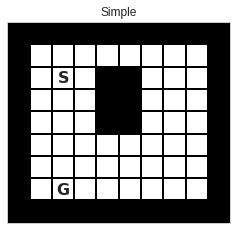

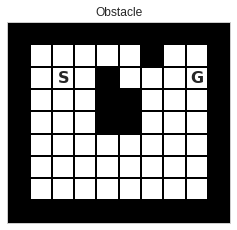

In [9]:
# @title Visualise GridWorlds { form-width: "30%" }

# Instantiate two tabular environments, a simple task, and one that involves
# the avoidance of an obstacle.
simple_grid = build_gridworld_task(
    task='simple', observation_type=ObservationType.GRID)
obstacle_grid = build_gridworld_task(
    task='obstacle', observation_type=ObservationType.GRID)

# Plot them.
simple_grid.plot_grid()
plt.title('Simple')

obstacle_grid.plot_grid()
plt.title('Obstacle');


In this environment, the agent has four possible  <font color='blue'>**actions**</font>: `up`, `right`, `down`, and `left`.  The <font color='green'>**reward**</font> is `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise. The episode ends when the agent reaches the goal, and otherwise continues. The **discount** on continuing steps, is $\gamma = 0.9$. 

Before we start building an agent to interact with this environment, let's first look at the types of objects the environment either returns (e.g. <font color='redorange'>**observations**</font>) or consumes (e.g. <font color='blue'>**actions**</font>). The `environment_spec` will show you the form of the <font color='redorange'>**observations**</font>, <font color='green'>**rewards**</font> and **discounts** that the environment exposes and the form of the <font color='blue'>**actions**</font> that can be taken.


In [10]:
# Note: setup_environment is implemented in the same cell as GridWorld.
environment, environment_spec = setup_environment(simple_grid)

print('actions:\n', environment_spec.actions, '\n')
print('observations:\n', environment_spec.observations, '\n')
print('rewards:\n', environment_spec.rewards, '\n')
print('discounts:\n', environment_spec.discounts, '\n')

actions:
 DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 

observations:
 Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 

rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward') 

discounts:
 BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 




We first set the environment to its initial location by calling the `reset()` method which returns the first observation. 


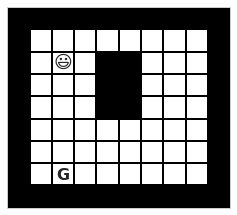

In [11]:
environment.reset()
environment.plot_state() 

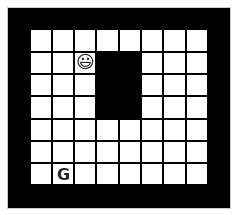

In [16]:
#@title Pick an action and see the state changing
action = 1 #@param ["0", "1", "2", "3"] {type:"raw"}

action = int(action) 
timestep = environment.step(action)  # pytype: dm_env.TimeStep
environment.plot_state()

###Question 1

In [17]:
# Enter one of the actions you tried above
action = 1
grader.grade(test_case_id='test_action', answer = action)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [18]:
#@title Implement the run loop  { form-width: "30%" }

def run_loop(
    environment: dm_env.Environment,
    agent: acme.Actor,
    num_episodes: Optional[int] = None,
    num_steps: Optional[int] = None,
    logger_time_delta: float = .25,
    label: str = 'training_loop',
    log_loss: bool = False,
):
  """Perform the run loop.

  We are following the Acme run loop.

  Run the environment loop for `num_episodes` episodes. Each episode is itself
  a loop which interacts first with the environment to get an observation and
  then give that observation to the agent in order to retrieve an action. Upon
  termination of an episode a new episode will be started. If the number of
  episodes is not given then this will interact with the environment
  infinitely.

  Args:
    environment: dm_env.Environment used to generate trajectories.
    agent: acme.Actor for selecting actions in the run loop.
    num_steps: number of steps to run the loop for. If `None` (default), runs
      without limit.
    num_episodes: number of episodes to run the loop for. If `None` (default),
      runs without limit.
    logger_time_delta: time interval (in seconds) between consecutive logging
      steps.
    label: optional label used at logging steps.
  """
  logger = loggers.TerminalLogger(label=label, time_delta=logger_time_delta)
  iterator = range(num_episodes) if num_episodes else itertools.count()
  all_returns = []
  
  num_total_steps = 0
  for episode in iterator:
    # Reset any counts and start the environment.
    start_time = time.time()
    episode_steps = 0
    episode_return = 0
    episode_loss = 0

    timestep = environment.reset()
    
    # Make the first observation.
    agent.observe_first(timestep)

    # Run an episode.
    while not timestep.last():
      # Generate an action from the agent's policy and step the environment.
      action = agent.select_action(timestep.observation)
      timestep = environment.step(action)

      # Have the agent observe the timestep and let the agent update itself.
      agent.observe(action, next_timestep=timestep)
      agent.update()

      # Book-keeping.
      episode_steps += 1
      num_total_steps += 1
      episode_return += timestep.reward

      if log_loss:
        episode_loss += agent.last_loss

      if num_steps is not None and num_total_steps >= num_steps:
        break

    # Collect the results and combine with counts.
    steps_per_second = episode_steps / (time.time() - start_time)
    result = {
        'episode': episode,
        'episode_length': episode_steps,
        'episode_return': episode_return,
    }
    if log_loss:
      result['loss_avg'] = episode_loss / episode_steps

    all_returns.append(episode_return)

    # Log the given results.
    logger.write(result)
    
    if num_steps is not None and num_total_steps >= num_steps:
      break

  return all_returns

In [19]:
#@title Implement the evaluation loop { form-width: "30%" }

def evaluate(environment: dm_env.Environment,
             agent: acme.Actor,
             evaluation_episodes: int):
  frames = []

  for episode in range(evaluation_episodes):
    timestep = environment.reset()
    episode_return = 0
    steps = 0
    while not timestep.last():
      frames.append(environment.plot_state(return_rgb=True))

      action = agent.select_action(timestep.observation)
      timestep = environment.step(action)
      steps += 1
      episode_return += timestep.reward
    print(
        f'Episode {episode} ended with reward {episode_return} in {steps} steps'
    )
  return frames

def display_video(frames: Sequence[np.ndarray],
                  filename: str = 'temp.mp4',
                  frame_rate: int = 12):
  """Save and display video."""
  # Write the frames to a video.
  with imageio.get_writer(filename, fps=frame_rate) as video:
    for frame in frames:
      video.append_data(frame)

  # Read video and display the video.
  video = open(filename, 'rb').read()
  b64_video = base64.b64encode(video)
  video_tag = ('<video  width="320" height="240" controls alt="test" '
               'src="data:video/mp4;base64,{0}">').format(b64_video.decode())
  return IPython.display.HTML(video_tag)


## Agent

We will be implementing Tabular & Function Approximation agents. Tabular agents are purely in Python and Function Approximation agents, we will use Tensorflow (v2).

All agents will share the same interface from the Acme `Actor`. Here we borrow a figure from Acme to show how this interaction occurs:


### Agent interface


<center><img src="https://drive.google.com/uc?id=1T7FTpA9RgDYFkciDFZK4brNyURZN_ZGp" width="500" /></center>

Each agent implements the following functions:

```python
class Agent(acme.Actor):
  def __init__(self, number_of_actions, number_of_states, ...):
    """Provides the agent the number of actions and number of states."""

  def select_action(self, observation):
    """Generates actions from observations."""

  def observe_first(self, timestep):
    """Records the initial timestep in a trajectory."""
  
  def observe(self, action, next_timestep):
    """Records the transition which occurred from taking an action."""

  def update(self):
    """Updates the agent's internals to potentially change its behavior."""
```

Remarks on the `observe()` function:

1. In the last method, the `next_timestep` provides the `reward`, `discount`, and `observation` that resulted from selecting `action`.

2. The `next_timestep.step_type` will be either `MID` or `LAST` and should be used to determine whether this is the last observation in the episode.

3. The `next_timestep.step_type` cannot be `FIRST`; such a timestep should only ever be given to `observe_first()`.


### Random Agent

We can just choose actions randomly to move around this environment.

In [20]:
#@title Implementation  { form-width: "30%" }

class RandomAgent(acme.Actor):

  def __init__(self, environment_spec):
    """Gets the number of available actions from the environment spec."""
    self._num_actions = environment_spec.actions.num_values

  def select_action(self, observation):
    """Selects an action uniformly at random."""
    return np.random.randint(self._num_actions)    
    
  def observe_first(self, timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def observe(self, action, next_timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def update(self):    
    """Does not update as the RandomAgent does not learn from data."""
    pass

In [21]:
#@title Visualisation { form-width: "30%" }

# Create the agent by giving it the action space specification.
agent = RandomAgent(environment_spec)

# Run the agent in the evaluation loop, which returns the frames.
frames = evaluate(environment, agent, evaluation_episodes=1)

# Visualize the random agent's episode.
display_video(frames)

### NOTE: Do not worry if the display_video gives an error. This appears to be due to some package dependency changes that also affected the original tutorial.

Episode 0 ended with reward -190.0 in 200 steps


ImportError: ignored

## Question 2

In [22]:
# Report the reward you got at the end of episode 0 with the Random Agent
reward = 190.0
grader.grade(test_case_id='test_random_agent_reward', answer = reward)

Correct! You earned 2.0/2.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Part 1 - Value-based methods: Model-free Tabular Agents

The first set of execises are based on the simple case where the number of states is small enough for our agents to maintain a table of values for each individual state that it will ever encounter: hence the name _tabular_.

We will cover two basic RL tabular algorithms:
- **On-policy**: SARSA 
- **Off-policy**: $\color{green}Q$-learning

Tabular agents expose a property `q_values` which returns a matrix of $\color{green}Q$-values
of shape (`num_states`, `num_actions`).

In particular, we will consider the case where the GridWorld has a fixed layout, and the goal is always at the same location, hence the state is fully determined by the location of the agent. As such, the <font color='orangered'>**observation**</font> from the environment is changed to be an integer corresponding to each one of the 90 locations on the grid. Notice the different observation specification below.


In [23]:
# Create the environment.
grid = build_gridworld_task(
    task='simple',
    observation_type=ObservationType.STATE_INDEX,  # Notice the difference here.
    max_episode_length=200)
environment, environment_spec = setup_environment(grid)

# Notice the difference between this observation specification and that above.
print('observation specification:\n', environment_spec.observations)

observation specification:
 DiscreteArray(shape=(), dtype=int32, name=observation_state_index, minimum=0, maximum=89, num_values=90)


In [24]:
#@title Implement helpers for value visualisation  { form-width: "30%" }

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
      

def smooth(x, window=10):
  return x[:window*(len(x)//window)].reshape(len(x)//window, window).mean(axis=1)
  
def plot_stats(stats, window=10):
  plt.figure(figsize=(16,4))
  plt.subplot(121)
  xline = range(0, len(stats.episode_lengths), window)
  plt.plot(xline, smooth(stats.episode_lengths, window=window))
  plt.ylabel('Episode Length')
  plt.xlabel('Episode Count')
  plt.subplot(122)
  plt.plot(xline, smooth(stats.episode_rewards, window=window))
  plt.ylabel('Episode Return')
  plt.xlabel('Episode Count')

## 1.1 On-policy control: SARSA Agent
In this section, we are focusing on control RL algorithms, which perform the **evaluation** and **improvement** of the policy synchronously. That is, the policy that is being evaluated improves as the agent is using it to interact with the environent.


The first algorithm we are going to be looking at is SARSA. This is an **on-policy algorithm** -- i.e: the data collection is done by leveraging the policy we're trying to optimize. 

As discussed during lectures, a greedy policy with respect to a given $\color{Green}Q$ fails to explore the environment as needed; we will use instead an $\epsilon$-greedy policy with respect to $\color{Green}Q$.

### SARSA Algorithm

**Input:**
- $\epsilon \in (0, 1)$ the probability of taking a random action , and
- $\alpha > 0$ the step size, also known as learning rate.

**Initialize:** $\color{green}Q(\color{red}{s}, \color{blue}{a})$ for all $\color{red}{s}$ ∈ $\mathcal{\color{red}S}$ and $\color{blue}a$ ∈ $\mathcal{\color{blue}A}$

**Loop forever:**

1. Get $\color{red}s \gets{}$current (non-terminal) state
 
2. Select $\color{blue}a \gets{} \text{epsilon_greedy}(\color{green}Q(\color{red}s, \cdot))$
 
3. Step in the environment by passing the selected action $\color{blue}a$

4. Observe resulting reward $\color{green}r$, discount $\gamma$, and state $\color{red}{s'}$

5. Compute TD error: $\Delta \color{green}Q \gets 
\color{green}r + \gamma \color{green}Q(\color{red}{s'}, \color{blue}{a'}) − \color{green}Q(\color{red}s, \color{blue}a)$, <br> where $\color{blue}{a'} \gets \text{epsilon_greedy}(\color{green}Q(\color{red}{s'}, \cdot))$

5. Update $\color{green}Q(\color{red}s, \color{blue}a) \gets \color{green}Q(\color{red}s, \color{blue}a) + \alpha \Delta \color{green}Q$


### Implement epsilon-greedy

In [25]:
# @title **[Coding task]** Epilson-greedy policy { form-width: "30%" }

def epsilon_greedy(
    q_values_at_s: np.ndarray,  # Q-values in state s: Q(s, :).
    epsilon: float = 0.1,  # Probability of taking a random action.
):
  """Return an epsilon-greedy action sample."""
  pass

In [26]:
# @title **[Solution]** Epilson-greedy policy { form-width: "30%" }

def epsilon_greedy(
    q_values_at_s: np.ndarray,  # Q-values in state s: Q(s, :).
    epsilon: float = 0.1,  # Probability of taking a random action.
):
  """Return an epsilon-greedy action sample."""
  if epsilon < np.random.random():
    # Greedy: Pick action with the largest Q-value.
    return np.argmax(q_values_at_s)
  else:
    # Get the number of actions from the size of the given vector of Q-values.
    num_actions = np.array(q_values_at_s).shape[-1]
    return np.random.randint(num_actions)

### Implement SARSA

In [27]:
#@title **[Coding task]** SARSA Agent  { form-width: "30%" }

class SarsaAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               epsilon: float,
               step_size: float = 0.1
               ):
    
    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size
    self._epsilon = epsilon

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None
    
  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return epsilon_greedy(self._q[observation], self._epsilon)
    
  def observe_first(self, timestep):
    # Set current state.
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    
    # ============ YOUR CODE HERE =============
    # Compute the on-policy Q-value update.
    # self._td_error =
    pass

  def update(self):
    # ============ YOUR CODE HERE =============
    # Update the Q-value table.
    pass

In [28]:
#@title **[Solution]** SARSA Agent { form-width: "30%" }

class SarsaAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               epsilon: float,
               step_size: float = 0.1
               ):
    
    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size
    self._epsilon = epsilon

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None
    
  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return epsilon_greedy(self._q[observation], self._epsilon)
    
  def observe_first(self, timestep):
    # Set current state.
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation

    # Compute the action that would be taken from the next state.
    next_a = self.select_action(next_s)
    
    # Compute the on-policy Q-value update.
    self._action = a
    self._next_state = next_s
    self._td_error = r + g * self._q[next_s, next_a] - self._q[s, a]

  def update(self):
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action

    # Update the Q-value table value at (s, a).
    self._q[s, a] += self._step_size * self._td_error

    # Update the current state.
    self._state = self._next_state

### **Task**: Run your SARSA agent on the `obstacle` environment

This environment is similar to the Cliff-walking example from [Sutton & Barto](http://incompleteideas.net/book/RLbook2018.pdf) and allows us to see the different policies learned by on-policy vs off-policy methods.

AFTER 100,000 STEPS ...


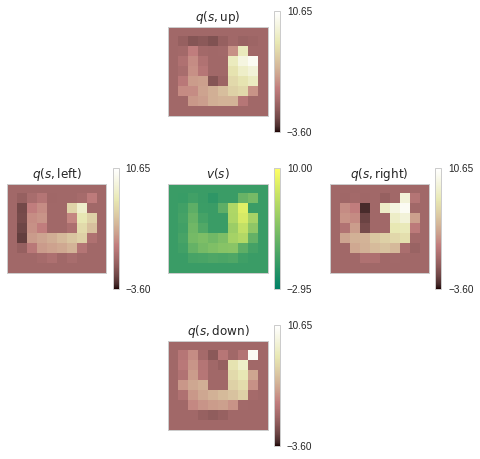

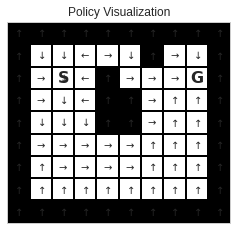

In [29]:
num_steps = 1e5 #@param {type:"number"}
num_steps = int(num_steps)

# Create the environment.
grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

# Create the agent.
agent = SarsaAgent(environment_spec, epsilon=0.1, step_size=0.1)

# Run the experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)
print('AFTER {0:,} STEPS ...'.format(num_steps))

# Get the Q-values and reshape them to recover grid-like structure of states.
q_values = agent.q_values
grid_shape = grid.layout.shape
q_values = q_values.reshape([*grid_shape, -1])

# Visualize the value and Q-value tables.
plot_action_values(q_values, epsilon=1.)

# Visualize the greedy policy.
environment.plot_greedy_policy(q_values)

## Question 3

In [30]:
# input a value of num_steps that you used to run the above execution of the SARSA Agent on the obstacle environment
num_steps = 100000
grader.grade(test_case_id='test_sarsa_num_steps', answer = num_steps)

Correct! You earned 2.0/2.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 1.2 Off-policy control: Q-learning Agent

Reminder: $\color{green}Q$-learning is a very powerful and general algorithm, that enables control (figuring out the optimal policy/value function) both on and off-policy.

**Initialize** $\color{green}Q(\color{red}{s}, \color{blue}{a})$ for all $\color{red}{s} \in \color{red}{\mathcal{S}}$ and $\color{blue}{a} \in \color{blue}{\mathcal{A}}$

**Loop forever**:

1. Get $\color{red}{s} \gets{}$current (non-terminal) state
 
2. Select $\color{blue}{a} \gets{} \text{behaviour_policy}(\color{red}{s})$
 
3. Step in the environment by passing the selected action $\color{blue}{a}$

4. Observe resulting reward $\color{green}{r}$, discount $\gamma$, and state, $\color{red}{s'}$

5. Compute the TD error: $\Delta \color{green}Q \gets \color{green}{r} + \gamma \color{green}Q(\color{red}{s'}, \color{blue}{a'}) − \color{green}Q(\color{red}{s}, \color{blue}{a})$, <br>
where $\color{blue}{a'} \gets \arg\max_{\color{blue}{\mathcal A}} \color{green}Q(\color{red}{s'}, \cdot)$

6. Update $\color{green}Q(\color{red}{s}, \color{blue}{a}) \gets \color{green}Q(\color{red}{s}, \color{blue}{a}) + \alpha \Delta \color{green}Q$

Notice that the actions $\color{blue}{a}$ and $\color{blue}{a'}$ are not selected using the same policy, hence this algorithm being **off-policy**.

In [31]:
#@title **[Coding task]** Q-Learning Agent  { form-width: "30%" }

QValues = np.ndarray
Action = int
# A value-based policy takes the Q-values at a state and returns an action.
ValueBasedPolicy = Callable[[QValues], Action]

class QLearningAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               behaviour_policy: ValueBasedPolicy,
               step_size: float = 0.1,
               ):
    
    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size

    # Store behavior policy.
    self._behaviour_policy = behaviour_policy

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None
    
  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])
    
  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    
    # ============ YOUR CODE HERE =============
    # Compute the offline Q-value update.
    # self._td_error =
    pass

  def update(self):
    # ============ YOUR CODE HERE =============
    pass

In [32]:
#@title **[Solution]** Q-Learning Agent { form-width: "30%" }

QValues = np.ndarray
Action = int
# A policy takes an observation and returns an action.
ValueBasedPolicy = Callable[[QValues], Action]

class QLearningAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               behaviour_policy: ValueBasedPolicy,
               step_size: float = 0.1,
               ):

    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size

    # Store behavior policy.
    self._behaviour_policy = behaviour_policy

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None
    
  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])
    
  def observe_first(self, timestep):
    # Set current state.
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    
    # Compute the TD error.
    self._action = a
    self._next_state = next_s
    self._td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]

  def update(self):
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action

    # Update the Q-value table value at (s, a).
    self._q[s, a] += self._step_size * self._td_error

    # Update the current state.
    self._state = self._next_state

### **Task 1**: Run your Q-learning agent on `obstacle`



AFTER 100,000 STEPS ...


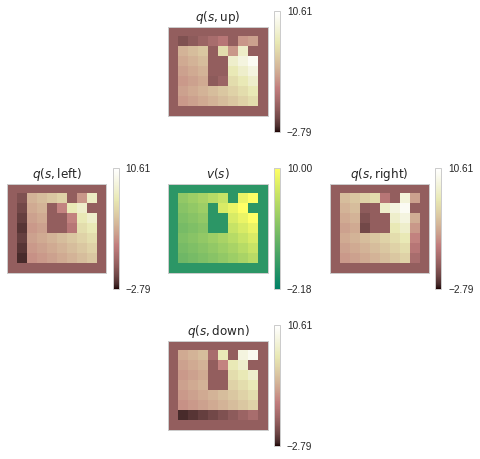

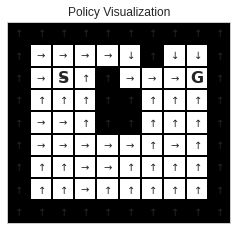

In [33]:
epsilon = 1.  #@param {type:"number"} 
num_steps = 1e5  #@param {type:"number"}
num_steps = int(num_steps)

# environment
grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = QLearningAgent(environment_spec, behavior_policy, step_size=0.1)

# run experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

# get the q-values
q = agent.q_values.reshape(grid.layout.shape + (4,))

# visualize value functions
print('AFTER {:,} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=0)

# visualise the greedy policy
grid.plot_greedy_policy(q)

## Question 4

In [34]:
# input the values of epsilon and num_steps you used above when running the Q-Learning Agent on the obstacle environment
epsilon = 1
num_steps =100000 
grader.grade(test_case_id='test_q_learning_obstacle', answer = [epsilon, num_steps])

Correct! You earned 2.0/2.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **Task 2:** Experiment with different levels of 'greediness'
* The default was $\epsilon=1.$, what does this correspond to?
* Try also $\epsilon =0.1, 0.5$. What do you observe? Does the behaviour policy affect the training in any way?

AFTER 100,000 STEPS ...


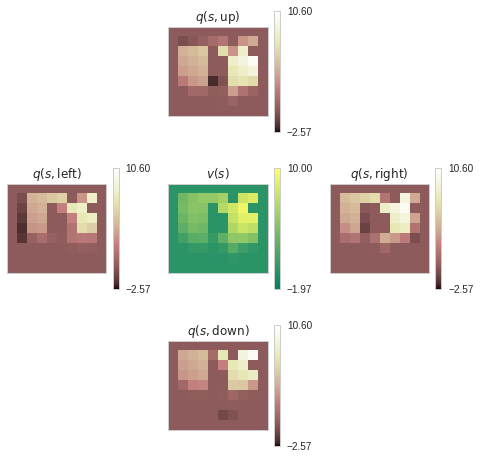

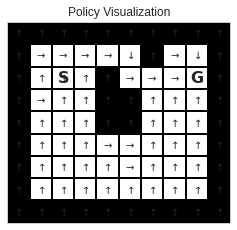

In [36]:
epsilon = 0.5  #@param {type:"number"} 
num_steps = 1e5  #@param {type:"number"}
num_steps = int(num_steps)

# environment
grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = QLearningAgent(environment_spec, behavior_policy, step_size=0.1)

# run experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

# get the q-values
q = agent.q_values.reshape(grid.layout.shape + (4,))

# visualize value functions
print('AFTER {:,} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=epsilon)

# visualise the greedy policy
grid.plot_greedy_policy(q)

## Question 5

In [37]:
# input a "greedier" value of epsilon that you used for Task 2
epsilon =0.1
grader.grade(test_case_id='test_q_learning_greedier', answer = epsilon)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 1.3 **[Try this later!]** Experience Replay

Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions using the behaviour policy
* accumulate all observed transitions $(\color{red}s, \color{blue}a, \color{green}r, \color{red}s')$ in the environment in a *replay buffer*,
* apply an online $\color{green}Q$-learning update
* apply multiple $\color{green}Q$-learning updates based on transitions sampled from the *replay buffer* (in addition to the online updates).


**Initialize:** $\color{green}Q(\color{red}s, \color{blue}a)$ for all $\color{red}{s} ∈ \mathcal{\color{red}S}$ and $\color{blue}a ∈ \mathcal{\color{blue}A}$

**Loop forever:**

1. Get $\color{red}{s} \gets{}$current (non-terminal) state
 
2. Select $\color{blue}{a} \gets{}  \text{behaviour_policy}(\color{red}{s})$
 
3. Step in the environment by passing the chosen action $\color{blue}{a}$

4. Observe resulting reward $\color{green}{r}$, discount $\gamma$, and state $\color{red}{s'}$

5. Apply online $\color{green}Q$-learning update<br>
$\color{green}Q(\color{red}{s}, \color{blue}{a}) \gets \color{green}Q(\color{red}{s}, \color{blue}{a}) + \alpha (\color{green}{r} + \gamma \color{green}Q(\color{red}{s'}, \color{blue}{a'}) − \color{green}Q(\color{red}{s}, \color{blue}{a}))$

5. Add transition $(\color{red}{s}, \color{blue}{a}, \color{green}{r}, \gamma, \color{red}{s'})$ to the replay buffer

6. Loop repeat n times:

  1. $(\color{red}{s}, \color{blue}{a}, \color{green}{r}, \gamma, \color{red}{s'}) \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  4. $\color{green}Q(\color{red}{s}, \color{blue}{a}) \gets \color{green}Q(\color{red}{s}, \color{blue}{a}) + \alpha (\color{green}{r} + \gamma \max_\color{blue}{a'} \color{green}Q(\color{red}{s'}, \color{blue}{a'}) − \color{green}Q(\color{red}{s}, \color{blue}{a}))$

In [38]:
#@title **[Coding task]** Q-learning with replay { form-width: "30%" }

class ReplayQLearningAgent(acme.Actor):

  def __init__(
      self,
      environment_spec: specs.EnvironmentSpec,
      behaviour_policy: ValueBasedPolicy, 
      num_offline_updates: int = 0,
      step_size: float = 0.1
  ): 

    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size
    self._num_offline_updates = num_offline_updates

    # Store behavior policy.
    self._behaviour_policy = behaviour_policy

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None

    # Create a container for experiences.
    self._replay_buffer = []
    
  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])
    
  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation

    # Compute the TD error.
    self._action = a
    self._next_state = next_s
    self._td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]

    if self._num_offline_updates > 0:
      # ============ YOUR CODE HERE =============
      # Update replay buffer.
      pass

  def update(self):
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action

    # Update the Q-value table value at (s, a).
    self._q[s, a] += self._step_size * self._td_error

    # Update the current state.
    self._state = self._next_state

    # Perform offline Q-value updates.
    # ============ YOUR CODE HERE =============

In [39]:
#@title **[Solution]**  Q-learning with replay { form-width: "30%" }

class ReplayQLearningAgent(acme.Actor):

  def __init__(
      self,
      environment_spec: specs.EnvironmentSpec,
      behaviour_policy: ValueBasedPolicy, 
      num_offline_updates: int = 0,
      step_size: float = 0.1
  ): 

    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size
    self._num_offline_updates = num_offline_updates

    # Store behavior policy.
    self._behaviour_policy = behaviour_policy

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None

    # Create a container for experiences.
    self._replay_buffer = []
    
  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])
    
  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation

    # Compute the TD error.
    self._action = a
    self._next_state = next_s
    self._td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]

    if self._num_offline_updates > 0:
      self._replay_buffer.append((s, a, r, g, next_s))

  def update(self):
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action

    # Update the Q-value table value at (s, a).
    self._q[s, a] += self._step_size * self._td_error

    # Update the current state.
    self._state = self._next_state

    # Perform offline Q-value updates.
    if len(self._replay_buffer) > self._num_offline_updates:
      for i in range(self._num_offline_updates):
        # Randomly sample from the replay buffer.
        idx = np.random.randint(0, len(self._replay_buffer))
        s, a, r, g, next_s = self._replay_buffer[idx]

        # Compute TD error of sampled transition.
        td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]

        # Perform an offline update.
        self._q[s, a] += self._step_size * td_error

#### **Task**: Compare Q-learning with/without experience replay

Use a small number of training steps (e.g. `num_steps = 1e3`) and vary `num_offline_updates` between `0` and `30`.

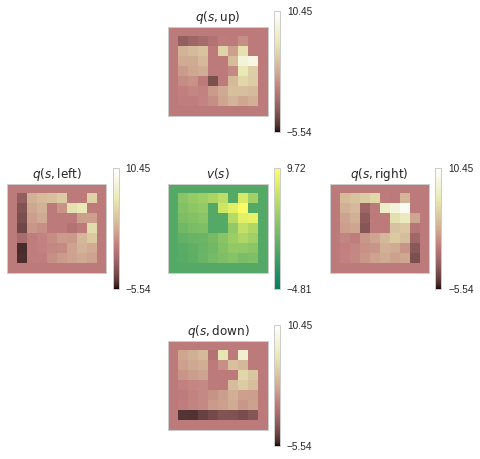

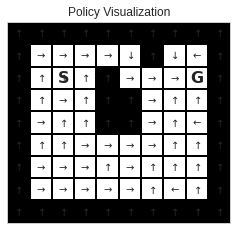

In [40]:
num_offline_updates = 20  # @param {type:"integer"}
epsilon = 1.  #@param {type:"number"} 
num_steps = 1e3  # @param {type: "number"}
num_steps = int(num_steps)

# Create the environment.
grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

agent = ReplayQLearningAgent(
    environment_spec,
    behaviour_policy=behavior_policy,
    num_offline_updates=num_offline_updates,
    step_size=0.1)

# Run experiment and get the value functions from agent.
returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

# Plot values and policy.
q = agent.q_values.reshape(grid.layout.shape + (4,))
plot_action_values(q)
grid.plot_greedy_policy(q)

## Question 6

In [41]:
# input the values of the parameters that you used above to test Q-learning with and without experience replay
num_offline_updates = 20
epsilon = 1
num_steps =1000 
grader.grade(test_case_id='test_exp_replay', answer = [num_offline_updates, epsilon, num_steps])

Correct! You earned 3.0/3.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Part 2 - Value-based methods: function approximation


<center>
<img src="https://drive.google.com/uc?id=1XIj68U3eB1bKYfIEHAcVbfwobmMYQQ4X" width="500" />
</center>

So far we only considered look-up tables for value-functions. In all previous cases every state and action pair $(\color{red}{s}, \color{blue}{a})$, had an entry in our $\color{green}Q$-table. Again, this is possible in this environment as the number of states is equal to the number of cells in the grid. But this is not scalable to situations where, say, the goal location changes or the obstacles are in different locations at every episode (consider how big the table could be in this situation?).

An example (not covered in this tutorial) is ATARI from pixels, where the number of possible frames an agent can see is exponential in the number of pixels on the screen.

<center><img width="200" alt="portfolio_view" src="https://miro.medium.com/max/1760/1*XyIpmXXAjbXerDzmGQL1yA.gif"></center>

But what we **really** want is just to be able to *compute* the Q-value, when fed with a particular $(\color{red}{s}, \color{blue}{a})$ pair. So if we had a way to get a function to do this work instead of keeping a big table, we'd get around this problem.

To address this, we can use **function approximation** as a way to generalize Q-values over some representation of the very large state space, and **train** them to output the values they should. In this section, we will explore $\color{green}Q$-learning with function approximation, which (although it has been theoretically proven to diverge for some degenerate MDPs) can yield impressive results in very large environments. In particular, we will look at [Neural Fitted Q (NFQ) Iteration](http://ml.informatik.uni-freiburg.de/former/_media/publications/rieecml05.pdf) and [Deep Q-Networks (DQN)](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf).



### Quick recap on replay

An important property of off-policy methods like $\color{green}Q$-learning is that they involve two policies: one for exploration and one that is being optimized (via the $\color{green}Q$-function updates). This means that we can generate data from the **behavior** policy and insert that data into some form of data storage---usually referred to as **replay**.

In order to optimize the $\color{green}Q$-function we can then sample data from the replay <font color='purple'>**dataset**</font> and use that data to perform an update. An illustration of this learning loop is shown below.

<center><img src="https://drive.google.com/uc?id=1ivTQBHWkYi_J9vWwXFd2sSWg5f2TB5T-" width="400" /></center> 

In the next section we will show how to implement a simple replay buffer. This can be as simple as a python list containing transition data. In more complicated scenarios we might want to have a more performance-tuned variant, we might have to be more concerned about how large replay is and what to do when its full, and we might want to sample from replay in different ways. But a simple python list can go a surprisingly long way.

## 2.0 Implement a simple replay buffer

In [42]:
#@title simple replay buffer  { form-width: "30%" }

# Create a convenient container for the SARS tuples required by deep RL agents.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])

class ReplayBuffer(object):
  """A simple Python replay buffer."""

  def __init__(self, capacity: int = None):
    self.buffer = collections.deque(maxlen=capacity)
    self._prev_state = None

  def add_first(self, initial_timestep: dm_env.TimeStep):
    self._prev_state = initial_timestep.observation

  def add(self, action: int, timestep: dm_env.TimeStep):
    transition = Transitions(
        state=self._prev_state,
        action=action,
        reward=timestep.reward,
        discount=timestep.discount,
        next_state=timestep.observation,
    )
    self.buffer.append(transition)
    self._prev_state = timestep.observation

  def sample(self, batch_size: int) -> Transitions:
    # Sample a random batch of Transitions as a list.
    batch_as_list = random.sample(self.buffer, batch_size)

    # Convert the list of `batch_size` Transitions into a single Transitions
    # object where each field has `batch_size` stacked fields.
    return tree_utils.stack_sequence_fields(batch_as_list)
  
  def flush(self) -> Transitions:
    entire_buffer = tree_utils.stack_sequence_fields(self.buffer)
    self.buffer.clear()
    return entire_buffer

  def is_ready(self, batch_size: int) -> bool:
    return batch_size <= len(self.buffer)

## 2.1 NFQ agent

[Neural Fitted Q Iteration](http://ml.informatik.uni-freiburg.de/former/_media/publications/rieecml05.pdf) was one of the first papers to demonstrate how to leverage recent advances in Deep Learning to approximate the Q-value by a neural network.$^1$
In other words, the value $\color{green}Q(\color{red}{s}, \color{blue}{a})$ are approximated by the output of a neural network $\color{green}{Q_w}(\color{red}{s}, \color{blue}{a})$ for each possible action $\color{blue}{a} \in \color{blue}{\mathcal{A}}$.$^2$

When introducing function approximations, and neural networks in particular, we need to have a loss to optimize. But looking back at the tabular setting above, you can see that we already have some notion of error: the **TD error**.

By training our neural network to output values such that the *TD error is minimized*, we will also satisfy the Bellman Optimality Equation, which is a good sufficient condition to enforce, to obtain an optimal policy.
Thanks to automatic differentiation, we can just write the TD error as a loss, e.g. with an $\ell^2$ loss, but others would work too:

$$L(\color{green}w) = \mathbb{E}\left[ \left( \color{green}{r} + \gamma \max_\color{blue}{a'} \color{green}{Q_w}(\color{red}{s'}, \color{blue}{a'}) − \color{green}{Q_w}(\color{red}{s}, \color{blue}{a})  \right)^2\right].$$

Then we can compute the gradient with respect to the parameters of the neural network and improve our Q-value approximation incrementally.

NFQ builds on $\color{green}Q$-learning, but if one were to update the Q-values online directly, the training can be unstable and very slow.
Instead, NFQ uses a replay buffer, similar to what you just implemented above, to update the Q-value in a batched setting.

When it was introduced, it also was entirely off-policy using a uniformly random policy to collect data, which was prone to instability when applied to more complex environments (e.g. when the input are pixels or the tasks are longer and more complicated).
But it is a good stepping stone to the more complex agents used today. Here, we will look at a slightly different and modernised implementation of NFQ.

<br />

---

<sub>$^1$ If you read the NFQ paper, they use a "control" notation, where there is a "cost to minimize", instead of "rewards to maximize", so don't be surprised if signs/max/min do not correspond.</sub>

<sub>$^2$ We could feed it $\color{blue}{a}$ as well and ask $Q_w$ for a single scalar value, but given we have a fixed number of actions and we usually need to take an $argmax$ over them, it's easiest to just output them all in one pass.</sub>

In [43]:
#@title **[Coding task]** NFQ Agent  { form-width: "30%" }

class NeuralFittedQAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               q_network: snt.Module,
               replay_capacity: int = 100_000,
               epsilon: float = 0.1,
               batch_size: int = 1,
               learning_rate: float = 3e-4):

    # Store agent hyperparameters and network.
    self._num_actions = environment_spec.actions.num_values
    self._epsilon = epsilon
    self._batch_size = batch_size
    self._q_network = q_network

    # Container for the computed loss (see run_loop implementation above).
    self.last_loss = 0.0

    # Create the replay buffer.
    self._replay_buffer = ReplayBuffer(replay_capacity)

    # Initialize network by feeding a dummy (batched) observation.
    dummy_observation = environment_spec.observations.generate_value()
    _ = self._q_network(dummy_observation[None, ...])

    # Setup optimizer that will train the network to minimize the loss.
    self._optimizer = snt.optimizers.Adam(learning_rate)

  def select_action(self, observation):
    # Compute Q-values.
    # Sonnet requires a batch dimension, which we squeeze out right after.
    q_values = self._q_network(observation[None, ...])  # Adds batch dimension.
    q_values = tf.squeeze(q_values, axis=0)  # Removes batch dimension.

    # Select epsilon-greedy action.
    if self._epsilon < tf.random.uniform(shape=()):
      action = tf.argmax(q_values, axis=-1)
    else:
      action = tf.random.uniform(
          shape=(), maxval=self._num_actions, dtype=tf.int32)

    return action

  def q_values(self, observation):
    q_values = self._q_network(observation[None, ...])
    return tf.squeeze(q_values, axis=0)

  def update(self):

    if not self._replay_buffer.is_ready(self._batch_size):
      # If the replay buffer is not ready to sample from, do nothing.
      return
    
    # Sample a minibatch of transitions from experience replay.
    transitions = self._replay_buffer.sample(self._batch_size)

    # Optionally unpack the transitions to lighten notation.
    # Note: each of these tensors will be of shape [batch_size, ...].
    s = transitions.state
    a = transitions.action
    r = transitions.reward
    d = transitions.discount
    next_s = transitions.next_state

    # Compute the Q-values at next states in the transitions.
    q_next_s = self._q_network(next_s)  # Shape [batch_size, num_actions].
    max_q_next_s = tf.reduce_max(q_next_s, axis=-1)  # Shape [batch_size].

    # Compute the TD error and then the losses.
    target_q_value = r + d * max_q_next_s

    # Note: the following computation must happen on Tensorflow's gradient tape
    # so that we can differentiate their result (loss) with respect to the
    # q_network trainable variables.
    with tf.GradientTape() as tape:

      # Compute the Q-values at original state.
      q_s = self._q_network(s)

      # Gather the Q-value corresponding to each action in the batch.
      q_s_a = tf.gather(q_s, a, axis=-1, batch_dims=1)

      # ============ YOUR CODE HERE =============
      # Compute the TD errors.
      td_error = ...

      # Average the squared TD errors over the entire batch (axis=0).
      loss = ...

    # Compute the gradients of the loss with respect to the q_network variables.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Apply the gradient update.
    self._optimizer.apply(gradients, q_network.trainable_variables)

    # Store the loss for logging purposes (see run_loop implementation above).
    self.last_loss = loss.numpy()

  def observe_first(self, timestep: dm_env.TimeStep):
    self._replay_buffer.add_first(timestep)

  def observe(self, action: int, next_timestep: dm_env.TimeStep):
    self._replay_buffer.add(action, next_timestep)

In [44]:
#@title **[Solution]** NFQ Agent  { form-width: "30%" }

# Create a convenient container for the SARS tuples required by NFQ.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])

class NeuralFittedQAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               q_network: snt.Module,
               replay_capacity: int = 100_000,
               epsilon: float = 0.1,
               batch_size: int = 1,
               learning_rate: float = 3e-4):

    # Store agent hyperparameters and network.
    self._num_actions = environment_spec.actions.num_values
    self._epsilon = epsilon
    self._batch_size = batch_size
    self._q_network = q_network

    # Container for the computed loss (see run_loop implementation above).
    self.last_loss = 0.0

    # Create the replay buffer.
    self._replay_buffer = ReplayBuffer(replay_capacity)

    # Initialize network by feeding a dummy (batched) observation.
    dummy_observation = environment_spec.observations.generate_value()
    _ = self._q_network(dummy_observation[None, ...])

    # Setup optimizer that will train the network to minimize the loss.
    self._optimizer = snt.optimizers.Adam(learning_rate)

  def select_action(self, observation):
    # Compute Q-values.
    # Sonnet requires a batch dimension, which we squeeze out right after.
    q_values = self._q_network(observation[None, ...])  # Adds batch dimension.
    q_values = tf.squeeze(q_values, axis=0)  # Removes batch dimension.

    # Select epsilon-greedy action.
    if self._epsilon < tf.random.uniform(shape=()):
      action = tf.argmax(q_values, axis=-1)
    else:
      action = tf.random.uniform(
          shape=(), maxval=self._num_actions, dtype=tf.int32)

    return action

  def q_values(self, observation):
    q_values = self._q_network(observation[None, ...])
    return tf.squeeze(q_values, axis=0)

  def update(self):

    if not self._replay_buffer.is_ready(self._batch_size):
      # If the replay buffer is not ready to sample from, do nothing.
      return
    
    # Sample a minibatch of transitions from experience replay.
    transitions = self._replay_buffer.sample(self._batch_size)

    # Optionally unpack the transitions to lighten notation.
    # Note: each of these tensors will be of shape [batch_size, ...].
    s = transitions.state
    a = transitions.action
    r = transitions.reward
    d = transitions.discount
    next_s = transitions.next_state

    # Compute the Q-values at next states in the transitions.
    q_next_s = self._q_network(next_s)  # Shape [batch_size, num_actions].
    max_q_next_s = tf.reduce_max(q_next_s, axis=-1)  # Shape [batch_size].

    # Compute the TD error and then the losses.
    target_q_value = r + d * max_q_next_s

    # Note: the following computation must happen on Tensorflow's gradient tape
    # so that we can differentiate their result (loss) with respect to the
    # q_network trainable variables.
    with tf.GradientTape() as tape:

      # Compute the Q-values at original state.
      q_s = self._q_network(s)

      # Gather the Q-value corresponding to each action in the batch.
      q_s_a = tf.gather(q_s, a, axis=-1, batch_dims=1)

      # Compute the TD errors.
      td_error = target_q_value - q_s_a

      # Average the squared TD errors over the entire batch (axis=0).
      loss = 0.5 * tf.reduce_mean(td_error ** 2, axis=0)

    # Compute the gradients of the loss with respect to the q_network variables.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Apply the gradient update.
    self._optimizer.apply(gradients, q_network.trainable_variables)

    # Store the loss for logging purposes (see run_loop implementation above).
    self.last_loss = loss.numpy()

  def observe_first(self, timestep: dm_env.TimeStep):
    self._replay_buffer.add_first(timestep)

  def observe(self, action: int, next_timestep: dm_env.TimeStep):
    self._replay_buffer.add(action, next_timestep)

### **Task: Train a NFQ agent**



In [45]:
#@title Training the NFQ Agent.  { form-width: "30%" }
epsilon = 0.5  # @param {type:"number"}

max_episode_length = 200

# Create the environment.
grid = build_gridworld_task(
    task='simple',
    observation_type=ObservationType.AGENT_GOAL_POS,
    max_episode_length=max_episode_length)
environment, environment_spec = setup_environment(grid)

# Define the neural function approximator (aka Q network).
q_network = snt.Sequential([
    snt.nets.MLP([50, 50, environment_spec.actions.num_values])
])

# Build the trainable Q-learning agent
agent = NeuralFittedQAgent(
    environment_spec,
    q_network,
    epsilon=epsilon,
    replay_capacity=100_000,
    batch_size=10,
    learning_rate=1e-3)

returns = run_loop(
    environment=environment,
    agent=agent,
    num_episodes=100,
    logger_time_delta=1.,
    log_loss=True)

### Evaluate the policy it learned

In [46]:
#@title Evaluating the agent.  { form-width: "30%" }

# Temporarily change epsilon to be more greedy; remember to change it back.
agent.epsilon = 0.05

# Record a few episodes.
frames = evaluate(environment, agent, evaluation_episodes=5)

# Change epsilon back.
agent.epsilon = epsilon

# Display the video of the episodes.
display_video(frames, frame_rate=6)

### NOTE: As before, do not worry if the display_video gives an error. This appears to be due to some package dependency changes that also affected the original tutorial.

Episode 0 ended with reward 10.0 in 21 steps
Episode 1 ended with reward -10.0 in 25 steps
Episode 2 ended with reward 0.0 in 11 steps
Episode 3 ended with reward 10.0 in 7 steps
Episode 4 ended with reward 10.0 in 13 steps


ImportError: ignored

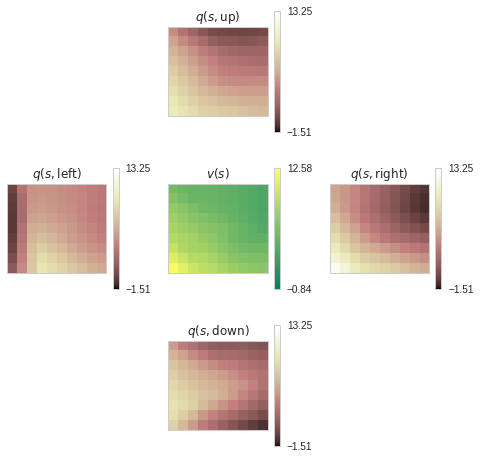

In [47]:
#@title Visualise the learned Q values

# Evaluate the policy for every state, similar to tabular agents above.

environment.reset()
pi = np.zeros(grid._layout_dims, dtype=np.int32)
q = np.zeros(grid._layout_dims + (4,))
for y in range(grid._layout_dims[0]):
  for x in range(grid._layout_dims[1]):
    # Hack observation to see what the Q-network would output at that point.
    environment.set_state(x, y)
    obs = environment.get_obs()
    q[y, x] = np.asarray(agent.q_values(obs))
    pi[y, x] = np.asarray(agent.select_action(obs))
    
plot_action_values(q)


## Question 7

In [48]:
# provide the epsilon value and reward at the end of epsiode 4
epsilon = 0.5
end_reward = 10.0
grader.grade(test_case_id='test_nfq_agent', answer = [epsilon, end_reward])

Correct! You earned 2.0/2.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 2.2 DQN from pixels


<!-- <center><img src="https://drive.google.com/uc?id=1ivTQBHWkYi_J9vWwXFd2sSWg5f2TB5T-" width="500" /></center>  -->

<center><img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnature14236/MediaObjects/41586_2015_Article_BFnature14236_Fig1_HTML.jpg" width="500" /></center> 

In this subsection, we will look at an advanced deep RL Agent based on the following publication, [Playing Atari with Deep Reinforcement Learning](https://deepmind.com/research/publications/playing-atari-deep-reinforcement-learning), which introduced the first deep learning model to successfully learn control policies directly from high-dimensional pixel inputs using RL.


In [49]:
#@title Create the environment with pixel observations

grid = build_gridworld_task(
    task='simple', 
    observation_type=ObservationType.GRID,
    max_episode_length=200)
environment, environment_spec = setup_environment(grid)

In [50]:
#@title Create an Acme DQN agent  { form-width: "30%" }

epsilon = 0.25  # @param {type: "number"}

# Build the agent's network.
q_network = snt.Sequential([
    snt.Conv2D(32, kernel_shape=[4,4], stride=[2,2], padding='VALID'),
    tf.nn.relu,
    snt.Conv2D(64, kernel_shape=[3,3], stride=[1,1], padding='VALID'),
    tf.nn.relu,
    snt.Flatten(),
    snt.nets.MLP([50, 50, environment_spec.actions.num_values])
])

# Use the DQN agent implementation from Acme.
agent = dqn.DQN(
    environment_spec=environment_spec,
    network=q_network,
    batch_size=10,
    samples_per_insert=2,
    epsilon=epsilon,
    min_replay_size=10,)

In [51]:
# @title Run a training loop  { form-width: "30%" }
# Rerun this cell until the agent has learned the given task.

# Train for `num_episodes` episodes.
returns = run_loop(
    environment=environment,
    agent=agent,
    num_episodes=300,
    num_steps=100_000)

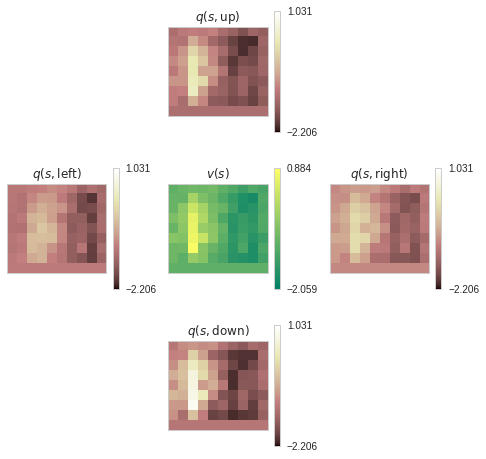

In [52]:
# @title Visualise the learned Q values { form-width: "30%" }

# Evaluate the policy for every state, similar to tabular agents above.
pi = np.zeros(grid._layout_dims, dtype=np.int32)
q = np.zeros(grid._layout_dims + (4,))
for y in range(grid._layout_dims[0]):
  for x in range(grid._layout_dims[1]):
    # Hack observation to see what the Q-network would output at that point.
    environment.set_state(x, y)
    obs = environment.get_obs()
    q[y, x] = np.asarray(agent._learner._network(np.expand_dims(obs, axis=0)))
    pi[y, x] = np.asarray(agent.select_action(obs))
    
plot_action_values(q)


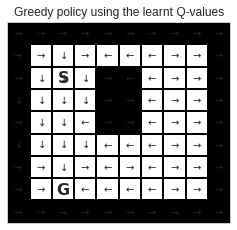

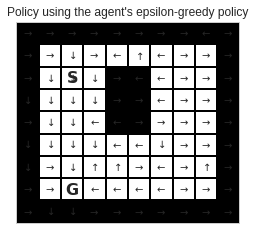

In [53]:
#@title Compare the greedy policy with the agent's policy { form-width: "30%" }

environment.plot_greedy_policy(q)
plt.title('Greedy policy using the learnt Q-values')

environment.plot_policy(pi)
plt.title("Policy using the agent's epsilon-greedy policy");

### Compare the greedy and behaviour ($\epsilon$-greedy) policies

Notice that the behaviour policy randomly flips arrows to random directions.

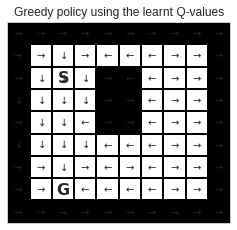

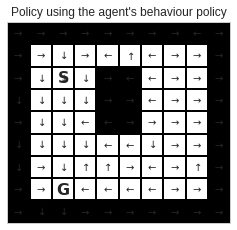

In [54]:
environment.plot_greedy_policy(q)
plt.title('Greedy policy using the learnt Q-values')

environment.plot_policy(pi)
plt.title("Policy using the agent's behaviour policy");

# Part 3: Policy Gradients

Now we will turn to policy gradient methods. Rather than defining the policy in terms a value function, i.e. $\color{blue}\pi(\color{red}s) = \arg\max_{\color{blue}a}\color{green}Q(\color{red}s, \color{blue}a)$, we will directly parameterize the policy and write it as the distribution

$$\color{blue}a \sim \color{blue}\pi_{\theta}(\color{blue}a|\color{red}s).$$

Here $\theta$ represent the parameters of the policy.

One convenient way to represent the conditional distribution above is as a function that takes a state $\color{red}s$ and returns a distribution over actions $\color{blue}a$. Exactly as we did above we will write this function as a `sonnet` module, but now we will assume the module returns a `Distribution` object as defined by `tensorflow_probability.distributions`. An instance of this object can be sampled from by calling the `sample` method, and we will show how to construct this module below.

Defined below is an agent using the same interface as above which implements the REINFORCE algorithm. Recall from the lecture notes that this algorithm computes the policy gradient:

$$
\nabla J(\theta) 
= \mathbb{E}
\left[
  \sum_{t=0}^T \color{green} G_t 
  \nabla\log\color{blue}\pi_\theta(\color{red}{s_t})
\right]
$$

where $\color{green} G_t$ is the sum over future rewards from time $t$, defined as

$$
\color{green} G_t 
= \sum_{n=t}^T \gamma^{n-t} 
\color{green} R(\color{red}{s_t}, \color{blue}{a_t}, \color{red}{s_{t+1}}).
$$

The algorithm below will collect the state, action, and reward data in its buffer until it reaches a full trajectory. It will then update its policy given the above gradient (and the Adam optimizer).

In [55]:
# @title Policy gradient agent: REINFORCE

class PolicyGradientAgent(acme.Actor):
  """Implements a vanilla policy gradient agent."""
  
  def __init__(
      self,
      # The policy network should output a tfp.distributions.Distribution.
      policy_network: snt.Module,
      discount: float = 0.9,
      learning_rate: float = 1e-3,
  ):

    # Store the policy neural network and the agent's discount.
    self.policy_network = policy_network
    self.discount = discount

    # Create the replay buffer to store transitions.
    self._replay_buffer = ReplayBuffer()

    # Flag to update agent, set to False until we've seen a full episode.
    self._should_update_agent = False

    # Create the optimizer that will be used to minimize the loss.   
    self.optimizer = snt.optimizers.Adam(learning_rate)

  def select_action(self, observation):
    # Pass the observation through the network to get the action distribution.
    action_distribution = self.policy_network(observation[None, ...])

    # Sample a single action.
    action = action_distribution.sample()

    # Convert to numpy and squeeze out the added batch dimension.
    action = action.numpy()
    return np.squeeze(action, axis=0)
  
  def observe(self, action, next_timestep: dm_env.TimeStep):
    self._replay_buffer.add(action, next_timestep)

    # If the transition lands in a terminal state, flag the agent to be updated.
    self._should_update_agent = next_timestep.last()
  
  def observe_first(self, timestep: dm_env.TimeStep):
    self._replay_buffer.add_first(timestep)
  
  def update(self):
    if not self._should_update_agent:
      return

    # Get transitions from the buffer and clear it.
    transitions = self._replay_buffer.flush()

    # Helper function to compute the reward-to-go.
    def sum_discounted_rewards(partial_sum, discount_and_reward):
      # Unpack the environment discount and reward.
      discount, reward = discount_and_reward
      # We also need to multiply by the agent's discount along the way.
      return reward + self.discount * discount * partial_sum

    # Compute the reward-to-go.
    G_t = tf.scan(sum_discounted_rewards,
                  (transitions.discount, transitions.reward),
                  reverse=True,
                  initializer=0.0)
    
    with tf.GradientTape() as tape:
      # Compute the action distribution and log-probabilities of taken actions.
      action_distribution = self.policy_network(transitions.state)
      logprobs = action_distribution.log_prob(transitions.action)

      # Compute the policy gradient loss.
      loss = -tf.reduce_sum(G_t * logprobs, axis=0)

    # Compute and apply the gradients.  
    gradients = tape.gradient(loss, self.policy_network.trainable_variables)
    self.optimizer.apply(gradients, self.policy_network.trainable_variables)

    # Reset the update flag.
    self._should_update_agent = False

In [56]:
#@title Training the policy gradient agent

num_steps = 1e5  # @param {type: "number"}

# Get number of available actions.
num_actions = environment_spec.actions.num_values

# Build the agent's network.
policy_network = snt.Sequential([     
    snt.Conv2D(32, kernel_shape=[4,4], stride=[2,2], padding='VALID'),
    tf.nn.relu,
    snt.Conv2D(64, kernel_shape=[3,3], stride=[1,1], padding='VALID'),
    tf.nn.relu,
    snt.Flatten(),
    snt.nets.MLP([50, 50, num_actions]),
    # This final layer outputs a categorical distribution with `num_actions`
    # possible outcomes. This distribution implements the
    # tfp.distribubtions.Distribution interface.
    tfp.distributions.Categorical,
])

# Create the agent.
agent = PolicyGradientAgent(policy_network)

# Create the environment with pixel observations
grid = build_gridworld_task(
    task='simple', 
    observation_type=ObservationType.GRID,
    max_episode_length=200)
environment, environment_spec = setup_environment(grid)

# Run a training loop
returns = run_loop(environment, agent, num_episodes=500, num_steps=num_steps)

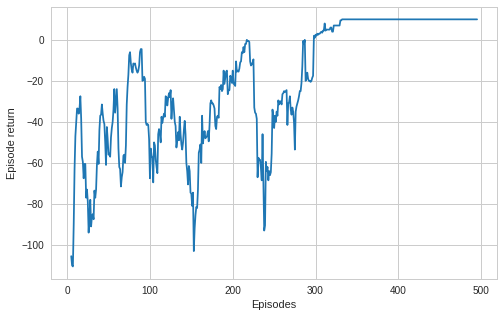

In [57]:
#@title Visualise the training curve { form-width: "30%" }

# Compute rolling average over returns
returns_avg = pd.Series(returns).rolling(10, center=True).mean()

plt.figure(figsize=(8, 5))
plt.plot(range(len(returns)), returns_avg)
plt.xlabel('Episodes')
plt.ylabel('Episode return');

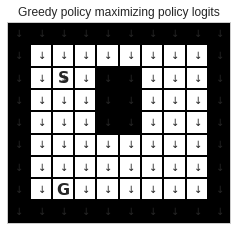

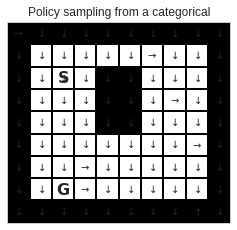

In [58]:
# @title Visualise learned policy

pi = np.zeros(grid._layout_dims, dtype=np.int32)
logits = np.zeros(grid._layout_dims + (num_actions,))

for y in range(grid._layout_dims[0]):
  for x in range(grid._layout_dims[1]):
    # Hack observation to see what the Q-network would output at that point.
    environment.set_state(x, y)
    obs = environment.get_obs()
    # We can reuse the policy network handle we passed to the agent.
    logits[y, x] = policy_network(obs[None, ...]).logits.numpy()
    pi[y, x] = np.asarray(agent.select_action(obs))

environment.plot_greedy_policy(logits)
plt.title('Greedy policy maximizing policy logits')

environment.plot_policy(pi)
plt.title("Policy sampling from a categorical");

One of the powers of policy search methods is generally how easily they can be applied to continuous control problems. In this tutorial we will continue to focus on discrete action environments in order to show the distinctions between policy-based and value-function methods. However, for an example of continuous action problems see the  [Acme tutorial](https://github.com/deepmind/acme/blob/master/examples/tutorial.ipynb).

# Question: Why are Agents Structured this way? 

In other words, why do we make a distinction between an Actor, an Agent, and a Learner? 

#Answer: 
This enables us to distribute single-process versions of these agents that uses exactly the same acting and learning code --- it's just constrained to a single process. This also allows us to attack offline-RL (also known as batch-RL) problems where you don't have any data generation and can only learn from a fixed dataset.

# Submitting to the Autograder


Now go to the File menu and choose "Download .ipynb".  Go to [Gradescope](https://www.gradescope.com/courses/409970) and:

1. From "File" --> Download both .ipynb and .py files
1. Name these files `Reinforcement_Learning_WS2.ipynb` and `Reinforcement_Learning_WS2.py` respectively
1. Sign in using your Penn email address (if you are a SEAS student we recommend using the Google login) and ensure  your class is "CIS 5200"
1. Select **Worksheet: Reinforcement Learning 2**
1. Upload both files
1. PLEASE CHECK THE AUTOGRADER OUTPUT TO ENSURE YOUR SUBMISSION IS PROCESSED CORRECTLY!

You should be set! Note that this assignment has 13 autograded points that will show up upon submission. Points are awarded based on a combination of correctness and sufficient effort.